# **Using Machine Learning to Reduce the Number of Daily Car Accidents**

Group 1: Rich Granato, Harim Shin, Kishan Rathor

Spring 2023 IST 718 Group Project

# Table of Contents

I. Abstract

II. Data Collection & Cleaning

III. Data Exploration & Insights

IV. Methodology

V. Model Predictions

VI. Model Inferences

VII. Conclusion

VIII. References


# I. Abstract

In 2021, an estimated 42,915 people died in the United States due to car accidents. (Forbes, 2023) There were two main objectives and goals that we had for this project. Objective 1: Predict severity of car accidents to help protect people **after** a car accident has already taken place. Objective 2: Identify common causes of car accidents to help prevent car accidents **before** they happen. We believe objective 1 results could be given to fire departments, police stations, and news media outlets to help protect people in the moment, and objective 2 results could be given to educational institutions and automobile companies to help educate and prevent accidents from happening in the future.

The scope of our data (retrieved from https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) contains car accident information across 49 U.S. states from 2016 to 2021. The dataset itself has roughly 2.8 million rows of data across 47 columns, containing 5 main groups of data: timing of accident, geographical location, weather conditions, road characteristics, and sunlight information.

For objective 1, we used Random Forest and Gradient Boosted models to predict the severity rating of a given car crash, which was converted from a 1-4 rating assigned by-hand after a car accident scenario has already concluded down to a 0-1 rating of either "severe" or "not severe". For objective 2, we utilized PCA, clustering analysis, logistic regression, and random forest to identify variables in the dataset that proved to be the best contributors to causing car accidents.

Our analysis yielded a wide variety of interesting results, and a small handful of issues along the way. Given the size of the dataset, we were forced to take a 1% sample in order to run each of our models. We also faced issues with the imbalance of the severity label, which had only 11% of the values at being "severe" and the remaining 89% at being "not severe". With that said, the best model for predicting severity (objective 1) was a random forest model with 3-fold cross validation, achieving an AUC of 0.71. From our analyses focused on inferences (objective 2), we discovered that distance traveled after impact is a strong indicator of how bad a car accident is, and through both our initial data exploration and importance vectors, discovered that wind speed is also a bit more impactful to driving conditions than many people may realize.

# II. Data Collection & Cleaning

After successfully getting the data into GitHub for easy access, we used Spark to import it into a dataframe. We dropped 16 variables due to either having too many NAs or not having a valuable contribution to the goals of our project. We also had to convert all of the remaining variables into either int or float as most of them were reading in as string. As previously mentioned, we converted the severity variable to be 0 or 1 instead of 1, 2, 3, or 4. At this point, we only had a select few values throughout the dataset that were reading as NA, so we decided to remove the rows associated with them. To handle the imbalance in the severity variable, specifically for use with the decision trees, we created weights based on the proportion of each value in the dataset and added them as a column in the dataframe. Lastly, we took our 1% sample that would be used for various analyses later in the project.

In [46]:
# install pyspark
%%bash
pip install pyspark &> /dev/null
pip install chart_studio &> /dev/null

# get data file from github
data_file=US_Accidents_Dec21_updated.csv
if [[ ! -f ./${data_file} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://media.githubusercontent.com/media/richgranato/IST718Spring2023ProjectGroup1/main/${data_file} &>/dev/null
fi

In [47]:
# create spark context
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as fn
from pyspark.ml import regression, evaluation, Pipeline, clustering
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, PCA, PCAModel
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, TimestampType, FloatType, BooleanType
from pyspark.sql.functions import year, asc
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import stat as st
from locale import normalize
from chart_studio import plotly
import plotly.graph_objects as go
from random import sample

In [48]:
# import car accidents dataset into a pyspark dataframe
car_acc = spark.read.option("header",True).csv("US_Accidents_Dec21_updated.csv")

In [49]:
# print the shape of the dataframe
print("Number of rows in the dataframe: ", car_acc.count())
print("Number of columns in the dataframe: ", len(car_acc.columns))

Number of rows in the dataframe:  2845342
Number of columns in the dataframe:  47


In [50]:
# display the first 5 rows of the data frame
car_acc.select(car_acc.columns[:9]).printSchema()
car_acc.select(car_acc.columns[:9]).show(5)
car_acc.select(car_acc.columns[9:20]).printSchema()
car_acc.select(car_acc.columns[9:20]).show(5)
car_acc.select(car_acc.columns[20:30]).printSchema()
car_acc.select(car_acc.columns[20:30]).show(5)
car_acc.select(car_acc.columns[30:43]).printSchema()
car_acc.select(car_acc.columns[30:43]).show(5)
car_acc.select(car_acc.columns[43:47]).printSchema()
car_acc.select(car_acc.columns[43:47]).show(5)

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)

+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|
+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
|A-1|       3|2016-02-08 00:37:08|2016-02-08 06:37:08|40.108909999999995|         -83.09286|          40.11206|         -83.03187|               3.23|
|A-2|       2|2016-02-08 05:56

In [51]:
# Severity variable counts
car_acc.groupBy("Severity").count().show()

# roughly 89% of data are categorized as 1 or 2, only 11% are categorized as 3 or 4

+--------+-------+
|Severity|  count|
+--------+-------+
|       3| 155105|
|       4| 131193|
|       2|2532991|
|       1|  26053|
+--------+-------+



In [52]:
drop_cols = ('Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'City', 'County', 'Airport_Code', 'Description', 'Number', 'Street', 'Zipcode', 'Country', 'Weather_Timestamp', 'Weather_Condition')

car_acc2 = car_acc.drop(*drop_cols).\
  withColumn("Severity", when(car_acc.Severity < 3, 0).when(car_acc.Severity >= 3, 1)).\
  withColumn("Distance(mi)", col("Distance(mi)").cast(FloatType())).\
  withColumn("Side", when(car_acc.Side == 'L', 0).when(car_acc.Side == 'R', 1)).\
  withColumn("Timezone", when(car_acc.Timezone == 'US/Eastern', 0).when(car_acc.Timezone == 'US/Central', 1).when(car_acc.Timezone == 'US/Mountain', 2).when(car_acc.Timezone == 'US/Pacific', 3)).\
  withColumn("Temperature(F)", col("Temperature(F)").cast(FloatType())).\
  withColumn("Wind_Chill(F)", col("Wind_Chill(F)").cast(FloatType())).\
  withColumn("Humidity(%)", col("Humidity(%)").cast(FloatType())).\
  withColumn("Pressure(in)", col("Pressure(in)").cast(FloatType())).\
  withColumn("Visibility(mi)", col("Visibility(mi)").cast(FloatType())).\
  withColumn("Wind_Speed(mph)", col("Wind_Speed(mph)").cast(FloatType())).\
  withColumn("Precipitation(in)", col("Precipitation(in)").cast(FloatType())).\
  withColumn("Amenity", when(car_acc.Amenity == 'False', 0).when(car_acc.Amenity == 'True', 1)).\
  withColumn("Bump", when(car_acc.Bump == 'False', 0).when(car_acc.Bump == 'True', 1)).\
  withColumn("Crossing", when(car_acc.Crossing == 'False', 0).when(car_acc.Crossing == 'True', 1)).\
  withColumn("Give_Way", when(car_acc.Give_Way == 'False', 0).when(car_acc.Give_Way == 'True', 1)).\
  withColumn("Junction", when(car_acc.Junction == 'False', 0).when(car_acc.Junction == 'True', 1)).\
  withColumn("No_Exit", when(car_acc.No_Exit == 'False', 0).when(car_acc.No_Exit == 'True', 1)).\
  withColumn("Railway", when(car_acc.Railway == 'False', 0).when(car_acc.Railway == 'True', 1)).\
  withColumn("Roundabout", when(car_acc.Roundabout == 'False', 0).when(car_acc.Roundabout == 'True', 1)).\
  withColumn("Station", when(car_acc.Station == 'False', 0).when(car_acc.Station == 'True', 1)).\
  withColumn("Stop", when(car_acc.Stop == 'False', 0).when(car_acc.Stop == 'True', 1)).\
  withColumn("Traffic_Calming", when(car_acc.Traffic_Calming == 'False', 0).when(car_acc.Traffic_Calming == 'True', 1)).\
  withColumn("Traffic_Signal", when(car_acc.Traffic_Signal == 'False', 0).when(car_acc.Traffic_Signal == 'True', 1)).\
  withColumn("Turning_Loop", when(car_acc.Turning_Loop == 'False', 0).when(car_acc.Turning_Loop == 'True', 1)).\
  withColumn("Sunrise_Sunset", when(car_acc.Sunrise_Sunset == 'Day', 0).when(car_acc.Sunrise_Sunset == 'Night', 1)).\
  withColumn("Civil_Twilight", when(car_acc.Civil_Twilight == 'Day', 0).when(car_acc.Civil_Twilight == 'Night', 1)).\
  withColumn("Nautical_Twilight", when(car_acc.Nautical_Twilight == 'Day', 0).when(car_acc.Nautical_Twilight == 'Night', 1)).\
  withColumn("Astronomical_Twilight", when(car_acc.Astronomical_Twilight == 'Day', 0).when(car_acc.Astronomical_Twilight == 'Night', 1))

In [53]:
# print schema of newly transformed variables
car_acc2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): float (nullable = true)
 |-- Side: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Timezone: integer (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): float (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Amenity: integer (nullable = true)
 |-- Bump: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Give_Way: integer (nullable = true)
 |-- Junction: integer (nullable = true)
 |-- No_Exit: integer (nullable = true)
 |-- Railway: integer (nullable = true)
 |-- Roundabout: integer (nullable = true)
 |-- Station: integer (nullable = true)
 |-- Stop: integer (nullable = true)
 |-

In [54]:
# Drop rows with Null/NaN value
car_acc2_cleaned = car_acc2.dropna()
print("Number of rows in the dataframe: ", car_acc2_cleaned.count())
print("Number of columns in the dataframe: ", len(car_acc2_cleaned.columns))

Number of rows in the dataframe:  2212394
Number of columns in the dataframe:  31


In [55]:
# add weight column to imbalanced data for later use
car_acc2_cleaned = car_acc2_cleaned.withColumn('weight', fn.when(car_acc2_cleaned.Severity==0, 1/(2559044/2845342)).when(car_acc2_cleaned.Severity==1, 1/(286298/2845342)).otherwise('ERROR'))
car_acc2_cleaned = car_acc2_cleaned.withColumn('weight', car_acc2_cleaned['weight'].cast('float'))

# sample the large dataset (1%)
car_acc3 = car_acc2_cleaned.sample(0.01)
car_acc3_pd = car_acc3.toPandas()

# III. Data Exploration & Insights

●	Describe the results of your data exploration.

●	Provide some data exploration visualizations.

●	Tell me something interesting you learned about the data.

●	Maybe provide some statistical summaries

●	Maybe look at feature correlation

●	Example data exploration insight for a group using an airline flight delay dataset:  We found that there was a higher frequency of delayed  flights which originated at Chicago O’Hare airport as compared to other airports.  We found evidence that these delays were caused mainly by …

●	Do not include model inference in this section.  Machine learning model inference goes in it’s own section described below.


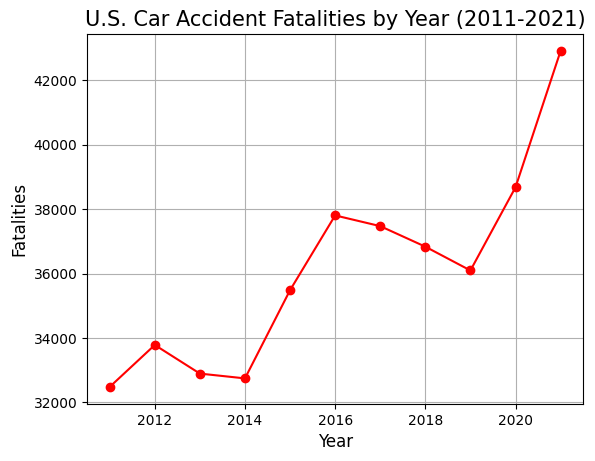

In [56]:
# Create Fatality Graph 2011-2021 (NHTSA, 2021)
fatalities_d = {'Year': [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'Fatalities': [32479, 33782, 32893, 32744, 35484, 37806, 37473, 36835, 36096, 38680, 42915]}
fatalities_df = pd.DataFrame(data=fatalities_d)

# Graph Data
plt.plot(fatalities_df['Year'], fatalities_df['Fatalities'], color='red', marker='o')
plt.title('U.S. Car Accident Fatalities by Year (2011-2021)', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Fatalities', fontsize=12)
plt.grid(True)
plt.show()

In [57]:
print("Car Accident Fatality Increase from 2011 to 2021: ", round(((42915-32479)/32479)*100,2),"%")

Car Accident Fatality Increase from 2011 to 2021:  32.13 %


In [58]:
acc_state = car_acc2[['Severity', 'State']]
acc_state_crosstab = acc_state.crosstab('State', 'Severity').orderBy('State_Severity')
acc_state_crosstab_prob = acc_state_crosstab.withColumn("prob_0", fn.round(fn.col("0") / (fn.col("0") + fn.col("1")), 2)).\
                                              withColumn("prob_1", fn.round(fn.col("1") / (fn.col("0") + fn.col("1")), 2)).\
                                              withColumnRenamed('State_Severity', 'State')

In [59]:
acc_state_crosstab_prob_pd = acc_state_crosstab_prob.toPandas()

In [60]:
fig = go.Figure(
    data=go.Choropleth(
        locations = acc_state_crosstab_prob_pd['State'], # Spatial coordinates
        z = acc_state_crosstab_prob_pd['prob_1'].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar_title = "Probability",
))

fig.update_layout(
    title_text = 'Severe Car Accident Probability by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

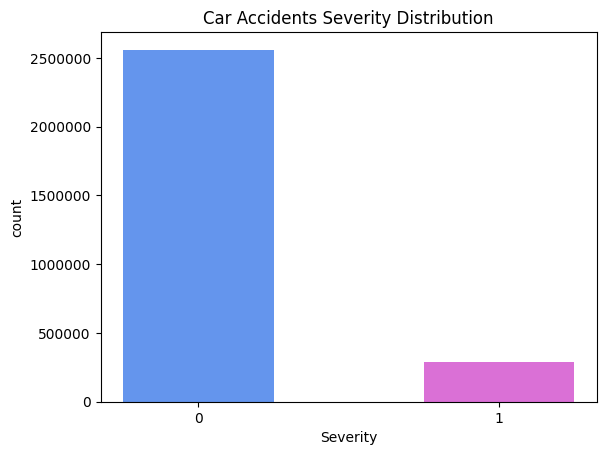

In [61]:
severity_dist = car_acc2.groupby('Severity').count().orderBy(col('Severity').asc()).toPandas()
plt.bar(severity_dist['Severity'], severity_dist['count'], width = 0.5, color = ['cornflowerblue', 'orchid'])
plt.xticks([0,1])
plt.xlabel('Severity')
plt.ylabel('count')
plt.title('Car Accidents Severity Distribution')
plt.ticklabel_format(scilimits=(0, 20))

Text(0.5, 1.0, 'Weather Features Correlation Heatmap')

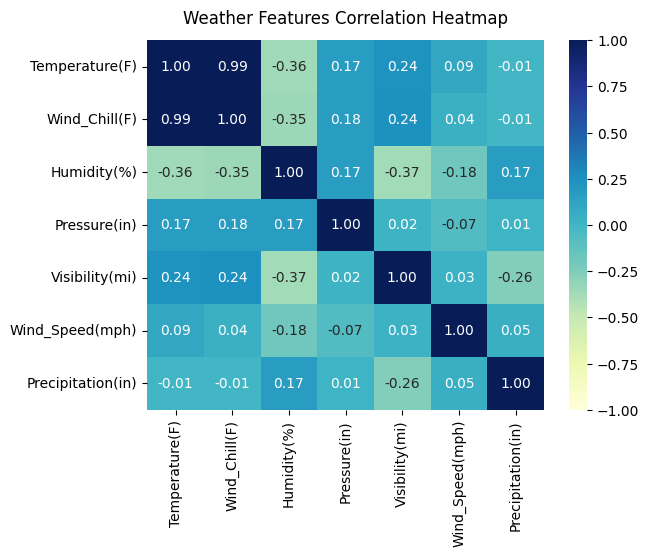

In [62]:
# Conduct analysis for the features related to weather

weather_list=['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
weather_df = car_acc3_pd[weather_list]
weather_df.head()
weather_corr = sns.heatmap(weather_df.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", fmt=".2f")
weather_corr.set_title('Weather Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

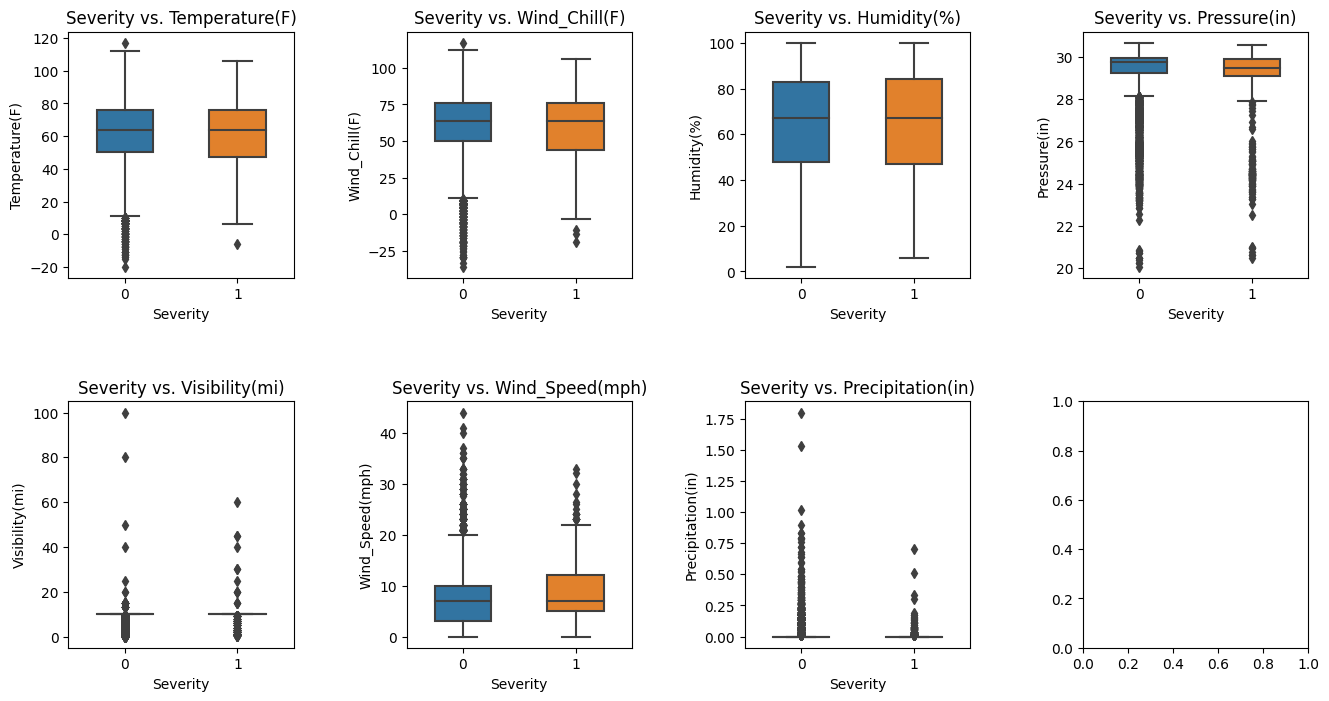

In [63]:
weather_severity_list = ['Severity','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

weather_severity_df = car_acc3_pd[weather_severity_list]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(len(weather_list)):
  sns.boxplot(ax = axes[i//4, i%4],
              x ='Severity', y = weather_list[i], 
              data = weather_severity_df, 
              width = 0.5).set(title = 'Severity vs. ' + weather_list[i])

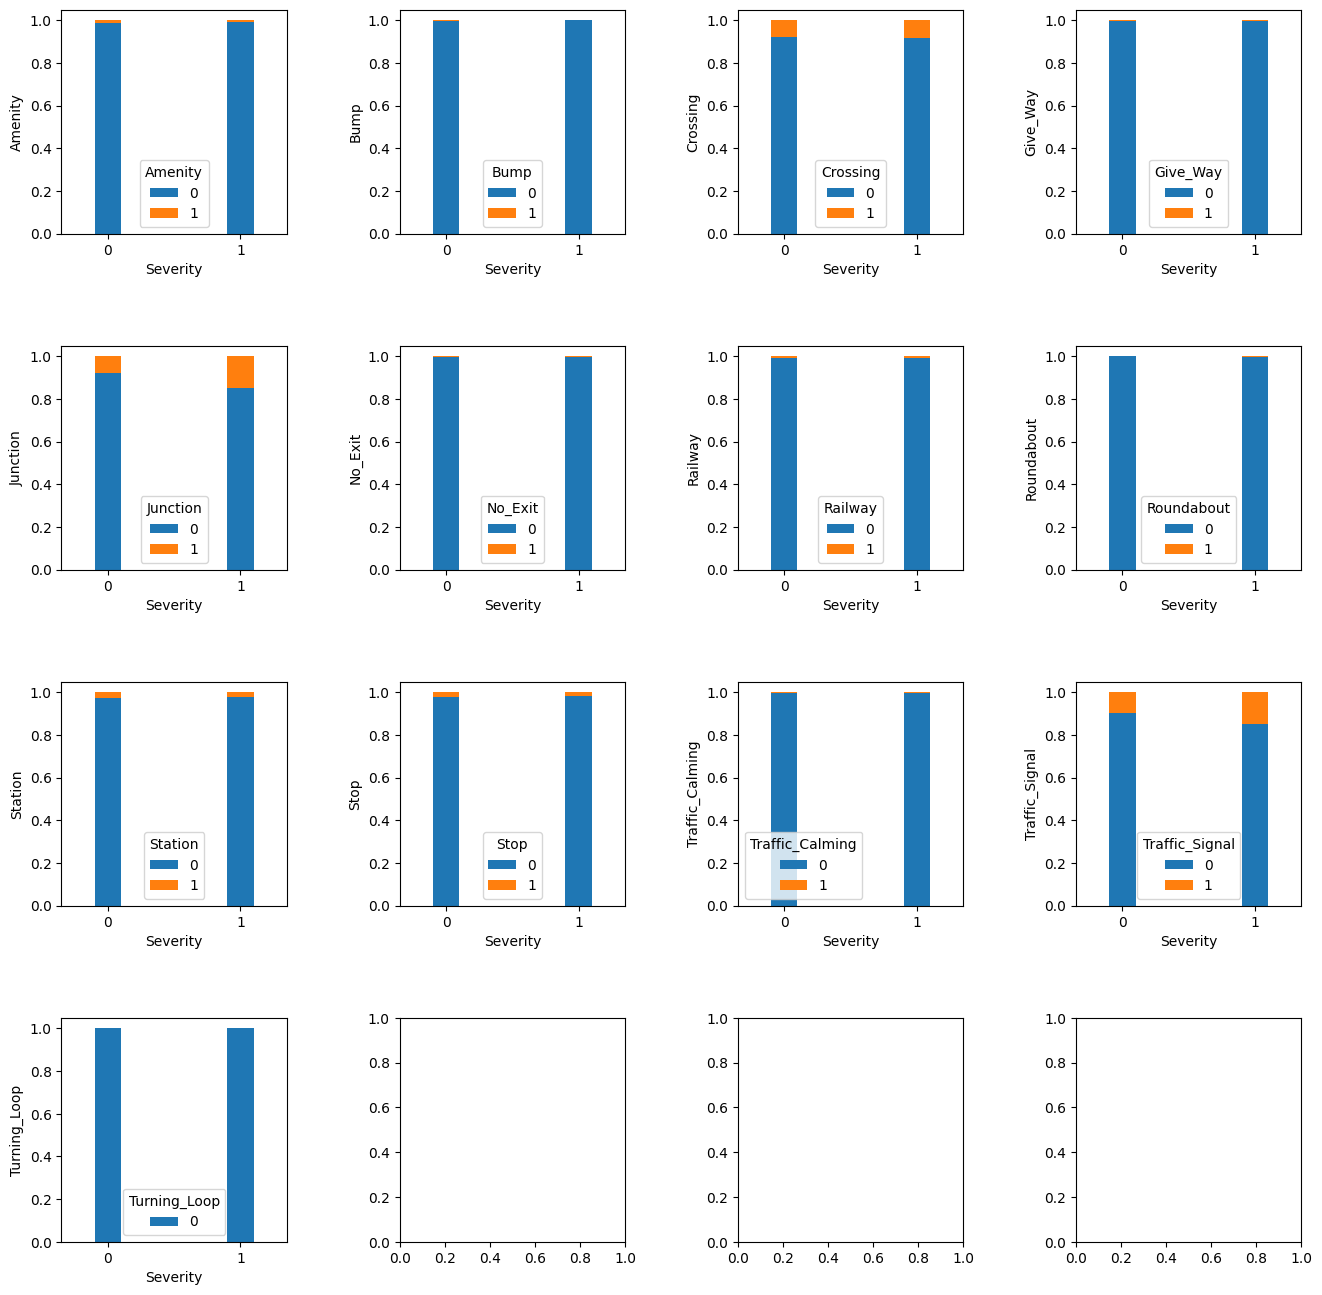

In [64]:
traffic_list = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(len(traffic_list)):
  ct = pd.crosstab(car_acc3_pd['Severity'], car_acc3_pd[traffic_list[i]]).apply(lambda r: r/r.sum(), axis=1)
  ct.plot(ax=axes[i//4, i%4], kind="bar", stacked=True, rot=0, width = 0.2, ylabel = traffic_list[i])

Text(0.5, 1.0, 'Traffic Features Correlation Heatmap')

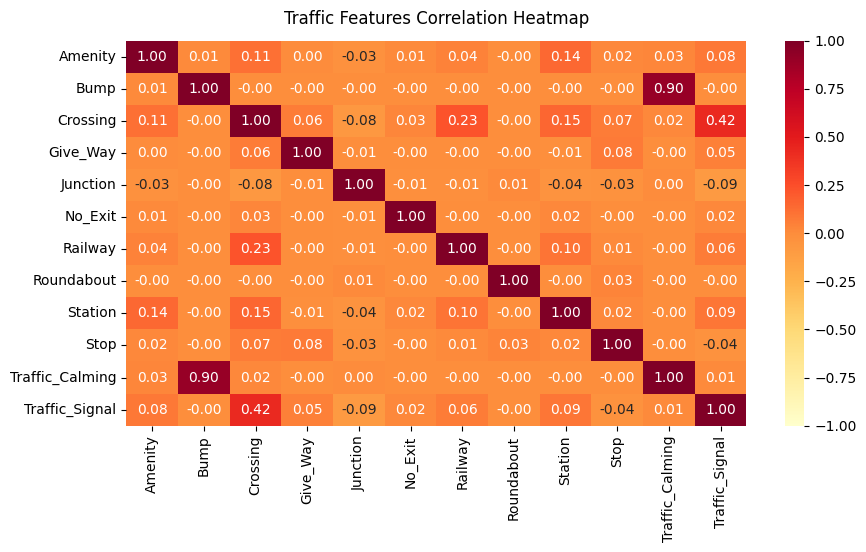

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
traffic_list_new = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'] # remove Turning_Loop
traffic_corr = sns.heatmap(car_acc3_pd[traffic_list_new].corr(), vmin=-1, vmax=1, annot=True, cmap="YlOrRd", fmt=".2f")
traffic_corr.set_title('Traffic Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

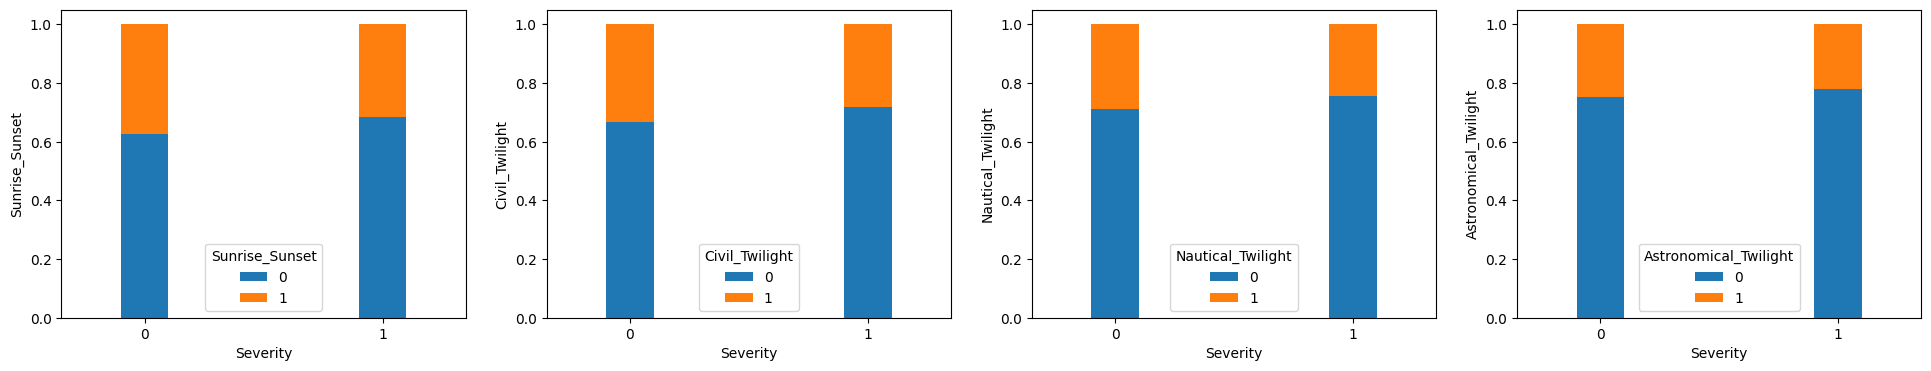

In [66]:
sunlight_list = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
fig, axes = plt.subplots(1,4, figsize = (24,4))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)
  
for i in range(len(sunlight_list)):
 ct = pd.crosstab(car_acc3_pd['Severity'], car_acc3_pd[sunlight_list[i]]).apply(lambda r: r/r.sum(), axis=1)
 ct.plot(ax=axes[i], kind = "bar", stacked = True, rot=0, width = 0.2, ylabel = sunlight_list[i])

Text(0.5, 1.0, 'Sunlight Features Correlation Heatmap')

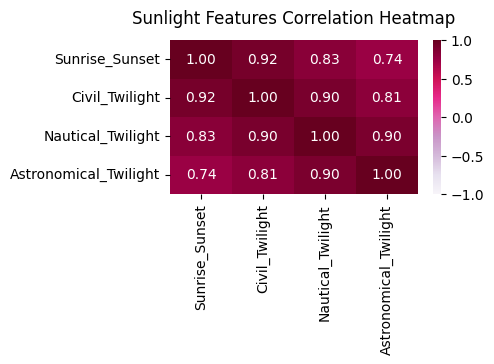

In [67]:
fig, ax = plt.subplots(figsize=(4, 2))
sunlight_corr = sns.heatmap(car_acc3_pd[sunlight_list].corr(), vmin=-1, vmax=1, annot=True, cmap="PuRd", fmt=".2f")
sunlight_corr.set_title('Sunlight Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [68]:
car_acc3.show(3)

+-------+--------+------------+----+-----+--------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+--------+
|     ID|Severity|Distance(mi)|Side|State|Timezone|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|  weight|
+-------+--------+------------+----+-----+--------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+-----

In [69]:
car_acc3.groupBy("Side").count().show()

+----+-----+
|Side|count|
+----+-----+
|   1|17616|
|   0| 4186|
+----+-----+



# IV. Methodology

●	Provide a brief description of the methodology used to achieve the goals of your project.  For example, if you are performing sentiment analysis on tweet data, describe the high-level methodology of your data science workflow to get your data ready to train models like stop word removal, word count, IDF, etc. 

●	Describe feature engineering / data transformations that are common to all of the models described in the following sections?  Example, you one hot encoded categorical variables that are used in all following models.  Or you reduced dimensionality by using PCA and trained all the following models using PCA scores. 

●	Describe the distribution of outcomes.  Is your dataset imbalanced or balanced and what is the distribution of outcomes.  Describe any sampling you may have done to balance your data set.

●	Describe your model scoring methodology.  Example 1: If you are making predictions on an unbalanced data set, describe how you adjusted your scoring methodology to account for the unbalanced outcomes.  If you are using a simple scoring metric then describe that.  Example 2: For model predictions we are using AUC to score the model’s ability to accurately predict delayed flights.

●	If you are using tools outside of spark this is a good place to describe how you are using that technology.  Do not say anything about seaborn, matplotlib, numpy, pandas, etc.  Only talk about uncommon tools that we have not used in class to support your project.

●	Feel free to use block diagrams / tables / diagrams to describe your workflow.  Note that I am not expecting you to present some off the shelf data science workflow; but rather, I want to know specifically what you needed to do on your project to get the ready for training your models.

# V. Model Predictions

•	A good technique for this section is to put each model in its own sub section with a descriptive title like Linear Regression Prediction of Flight Delay.  A lot of the requested information can be efficiently conveyed with a table (the same general table can be used for each model).  Or provide a combined summary table and text that describes the combined summary table.

•	For each summary table, include the following:
o	Value being predicted.
o	Model type: Random Forest, Linear Regression, neural network
o	Scoring metric: F1, AUC, MSE, RMSE, etc.
o	If cross validation was used.  Number of folds if used
o	Resulting Model Score

•	Provide brief text explanations for each table.  Describe things like transformations or feature engineering that was not common to all models and not described in the methodology section.  Describe things particular to this model that needed to be performed in order to meet your goals.

•	There is no need to overly complicate things in this section.  Don’t make things more complicated than they need to be.


# VI. Model Inferences

•	Same rules as for prediction above:  A good technique for this section is to put each model in its own sub section with a descriptive title like Linear Regression Inference of Flight Delay.  A lot of the requested information can be efficiently conveyed with a table (the same general table can be used for each model).  Or provide a combined summary table and text that describes the combined summary table.

•	For each summary table, include the following in some sorted order:
o	Feature Name
o	Feature metric being compared: Example: Regression coefficient, gini index, entropy, etc.
o	Scoring metric: F1, AUC, MSE, RMSE, etc.
o	If cross validation was used indicate that fact and the number of folds used to score your model.

•	For each table, provide a brief text explanation which highlights the following.  Provide a bullet or numbered list for each of the following:
o	The inference goal
o	What you learned through your analysis
o	Any special transformations / feature engineering you had to perform in order to correctly perform the inference.  For example, transformed the data using a standard scaler so regression coefficients representing real data could be compared between each other.
o	It is encouraged to stick with inference techniques covered in class.
o	There is no need to overly complicate things in this section.  Don’t make things more complicated than they need to be.

•	2 to 3 pages are advised for this section


# VII. Conclusion

●	Describe the results of the project by expanding upon the brief conclusion results outlined in the abstract.  Summarize model comparison results in a prediction summary table.  Summarize inference results in an inference summary table.  Sort the summary tables.  Use table column names which are similar to columns in previous sections.  Maybe add sub sections for prediction and inference summaries.  Provide results for every prediction and inference item presented in the abstract.  



# VII. References

*   Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
*   Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.
*   NHTSA’s National Center for Statistics and Analysis. (n.d.). Early Estimate of Motor Vehicle Traffic Fatalities for the First 9 Months (January–September) of 2021. Retrieved April 22, 2023, from https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813240 
*   Simon, S. (2023, January 27). How many people die from car accidents each year? Forbes. Retrieved March 4, 2023, from https://www.forbes.com/advisor/legal/auto-accident/car-accident-deaths/

# *THESE NEED TO BE MOVED TO CORRECT SUBHEADINGS*

Unsupervised Learning

In [70]:
# Unsupervised Learning - PCA

feature_list = car_acc3.drop('ID', 'Severity', 'State', 'Wind_Direction').columns


In [71]:
car_acc_pca = Pipeline(stages = [
    VectorAssembler(inputCols = feature_list, outputCol = 'features'),
    StandardScaler(inputCol = 'features', outputCol = 'zfeatures'),
    PCA(k=10, inputCol = 'zfeatures', outputCol = 'scores')
]).fit(car_acc3)

Text(0, 0.5, 'Proportion Variance Explained')

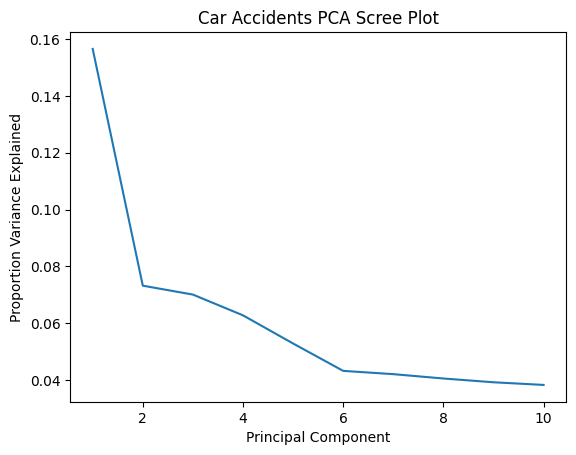

In [72]:
plt.figure()
pca_explained_var = car_acc_pca.stages[-1].explainedVariance
plt.plot(np.arange(1, len(pca_explained_var)+1), pca_explained_var)
plt.title("Car Accidents PCA Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

In [73]:
loadings = car_acc_pca.stages[-1].pc.toArray()

In [74]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

feature_loadings = []
for i in range(len(feature_list)):
  feature_loadings.append([
    feature_list[i], loadings[:, 0][i], loadings[:, 1][i], loadings[:, 2][i], loadings[:, 3][i], loadings[:, 4][i], 
    loadings[:, 5][i], loadings[:, 6][i], loadings[:, 7][i], loadings[:, 8][i], loadings[:, 9][i]
  ])

pd.DataFrame(
    feature_loadings, 
    columns=['feature', 'loading 1', 'loading 2', 'loading 3', 'loading 4', 'loading 5', 'loading 6', 'loading 7', 'loading 8', 'loading 9', 'loading 10']
  )

# list(zip(feature_list, loadings[:, 0], loadings[:, 1]))

,feature,loading 1,loading 2,loading 3,loading 4,loading 5,loading 6,loading 7,loading 8,loading 9,loading 10
0,Distance(mi),-0.0113,-0.1822,0.0830,-0.1552,0.0426,-0.3300,0.1409,-0.0016,-0.0284,-0.0530
1,Side,-0.0301,-0.1697,0.0898,-0.1833,0.0071,-0.2906,0.4614,-0.0154,-0.0884,0.1354
2,Timezone,-0.0245,-0.0567,0.0700,-0.1568,-0.3814,0.4356,0.4166,-0.0671,0.0426,-0.0228
3,Temperature(F),0.3056,0.3605,-0.1447,-0.2545,0.2399,0.0419,0.1585,0.1418,0.0828,-0.0957
4,Wind_Chill(F),0.2962,0.3679,-0.1485,-0.2600,0.2475,0.0607,0.1724,0.1303,0.0750,-0.0731
5,Humidity(%),-0.2321,-0.1674,0.0224,0.2768,0.4108,0.0160,-0.0377,-0.0564,-0.0633,0.1091
6,Pressure(in),0.0244,0.1401,-0.1051,0.0304,0.5345,-0.0268,-0.0614,-0.1995,-0.2432,0.2435
7,Visibility(mi),0.0984,0.2836,-0.1035,-0.3036,-0.2528,-0.1988,-0.2344,-0.0973,-0.1339,0.1006
8,Wind_Speed(mph),0.1375,-0.0589,0.0353,0.0691,-0.1080,-0.2643,-0.1593,0.2263,0.1527,-0.4456
9,Precipitation(in),-0.0091,-0.1246,0.0445,0.2037,0.3345,0.1505,0.3087,0.3325,0.2809,-0.3186


In [75]:
# # Unsupervised Learning - feature engineering

# va1 = VectorAssembler(inputCols = ['Distance(mi)', 'Temperature(F)'], outputCol = 'features1')
# ss = StandardScaler(inputCol = 'features1', outputCol = 'zfeatures')
# ohe = OneHotEncoder(inputCol = 'Timezone', outputCol = 'timezone_dummy')
# va2 = VectorAssembler(inputCols = ['zfeatures', 'timezone_dummy'], outputCol = 'features')

# featurize = Pipeline(stages = [va1,ss,ohe,va2]).fit(car_acc3)
# featurize.transform(car_acc3).select('features').show(5)

# featurize.transform(car_acc3).select('features').toPandas()

# ## Ordinal Logit? Logit?

In [76]:
# Unsupervised Learning - clustering
car_acc_clustering = Pipeline(stages=[
    VectorAssembler(inputCols = feature_list, outputCol='features'), 
    StandardScaler(inputCol='features', outputCol='std_features'), 
    clustering.KMeans(k=10, featuresCol='std_features', predictionCol='cluster')
    ]).fit(car_acc3)


In [77]:
cluster_analysis = car_acc_clustering.transform(car_acc3).groupBy('cluster').count().select('cluster', col('count').alias('n_accidents'))

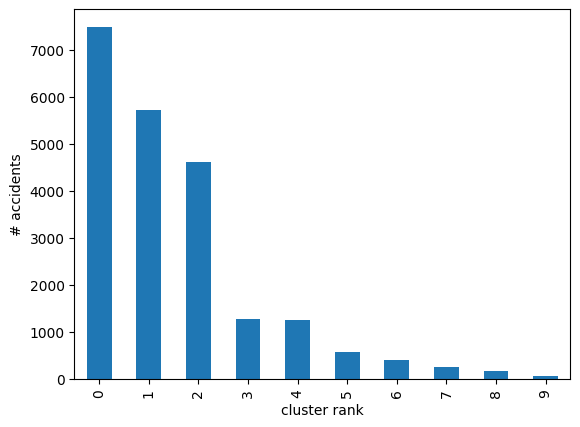

In [78]:
(cluster_analysis
 .toPandas()
 .sort_values('n_accidents', ascending=False)
 .reset_index()
 .n_accidents.plot(y='n_accidents', kind='bar')
);
plt.xlabel('cluster rank')
plt.ylabel('# accidents');


# percent of clusters

In [79]:
#plt.figure()
#clustering_explained_var = car_acc_clustering.stages[-1].explainedVariance
#plt.plot(np.arange(1, len(clustering_explained_var)+1), clustering_explained_var)
#plt.title("Car Accidents PCA Scree Plot")
#plt.xlabel("Principal Component")
#plt.ylabel("Proportion Variance Explained")

Decision Trees: Random Forest and Gradient Boosted Trees

In [80]:
# Random Forest Models

# drop columns that aren't needed
car_acc4 = car_acc3.drop("Wind_Direction", "Precipitation(in)", "ID", "Start_Time", "End_Time", "Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", 
                         "Number", "Street", "Side", "City", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", 
                         "Weather_Timestamp", "Weather_Condition", "Wind_Chill(F)", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight",
                         "Bump", "Give_Way", "No_Exit", "Roundabout", "Traffic_Calming", "Turning_Loop", "Amenity", "Railway", "Station", "Stop", "Crossing", "Junction")

# rename "Severity" variable to "label"
car_acc4 = car_acc4.withColumnRenamed('Severity', 'label')

# create training, validation, and testing datasets
training_df, validation_df, testing_df = car_acc4.randomSplit([0.6, 0.2, 0.2])

# create 3-fold random forest classification model
# Re-create variables and set up 3-fold cross validation
va = VectorAssembler().setInputCols(training_df.columns[1:7]).setOutputCol('features')
rf = RandomForestClassifier(numTrees = 25, maxDepth = 5, weightCol='weight')
rf_pipeline = Pipeline(stages=[va, rf])
paramGrid = ParamGridBuilder().build()
bce = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=paramGrid, evaluator=bce, numFolds=3)
rf_fitted = cv.fit(training_df)

# calculate AUC on validation set
print("RF AUC (validation): ",round(bce.evaluate(rf_fitted.transform(validation_df)),3))

# calculate AUC on testing set
print("RF AUC (testing): ",round(bce.evaluate(rf_fitted.transform(testing_df)),3))

# create importance dataframe
rf_model = rf_fitted.bestModel.stages[-1]
importance_df = pd.DataFrame(list(zip(training_df.columns[1:7], rf_model.featureImportances.toArray())), columns = ['feature', 'importance']).sort_values('importance', ascending=False)

# print importance dataframe
print(importance_df)

# create predictions confusion matrix
predictions = rf_fitted.transform(testing_df)
predictions2 = predictions.withColumn('TP', fn.when((predictions.label==1) & (predictions.prediction==1), 1).otherwise(0))
predictions2 = predictions2.withColumn('TN', fn.when((predictions2.label==0) & (predictions2.prediction==0), 1).otherwise(0))
predictions2 = predictions2.withColumn('FP', fn.when((predictions2.label==0) & (predictions2.prediction==1), 1).otherwise(0))
predictions2 = predictions2.withColumn('FN', fn.when((predictions2.label==1) & (predictions2.prediction==0), 1).otherwise(0))
print(predictions2.groupBy("TP").count().show())
print(predictions2.groupBy("TN").count().show())
print(predictions2.groupBy("FP").count().show())
print(predictions2.groupBy("FN").count().show())

# print one of the trees from the final model
print(rf_model.trees[0].toDebugString)

# Gradient Boosting (received better results with RF)
gbt = GBTClassifier(weightCol='weight')
gbt_pipeline = Pipeline(stages=[va, gbt])
paramGrid = ParamGridBuilder().build()
cv = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=paramGrid, evaluator=bce, numFolds=3)
gbt_fitted = cv.fit(training_df)

# calculate AUC
print("GBT AUC (validation): ",round(bce.evaluate(gbt_fitted.transform(validation_df)),3))
print("GBT AUC (testing): ",round(bce.evaluate(gbt_fitted.transform(testing_df)),3))

RF AUC (validation):  0.691
RF AUC (testing):  0.662
           feature  importance
3     Pressure(in)      0.3734
0     Distance(mi)      0.2937
1   Temperature(F)      0.1096
2      Humidity(%)      0.0851
5  Wind_Speed(mph)      0.0845
4   Visibility(mi)      0.0537
+---+-----+
| TP|count|
+---+-----+
|  0| 4382|
|  1|   40|
+---+-----+

None
+---+-----+
| TN|count|
+---+-----+
|  1| 4005|
|  0|  417|
+---+-----+

None
+---+-----+
| FP|count|
+---+-----+
|  1|  198|
|  0| 4224|
+---+-----+

None
+---+-----+
| FN|count|
+---+-----+
|  1|  179|
|  0| 4243|
+---+-----+

None
DecisionTreeClassificationModel: uid=dtc_f345d95a4916, depth=5, numNodes=51, numClasses=2, numFeatures=6
  If (feature 3 <= 29.785000801086426)
   If (feature 3 <= 24.925000190734863)
    If (feature 2 <= 52.5)
     If (feature 5 <= 10.199999809265137)
      Predict: 1.0
     Else (feature 5 > 10.199999809265137)
      If (feature 1 <= 67.5)
       Predict: 1.0
      Else (feature 1 > 67.5)
       Predict: 0.0
    

Supervised Learning

In [81]:
car_acc2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): float (nullable = true)
 |-- Side: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Timezone: integer (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): float (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Amenity: integer (nullable = true)
 |-- Bump: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Give_Way: integer (nullable = true)
 |-- Junction: integer (nullable = true)
 |-- No_Exit: integer (nullable = true)
 |-- Railway: integer (nullable = true)
 |-- Roundabout: integer (nullable = true)
 |-- Station: integer (nullable = true)
 |-- Stop: integer (nullable = true)
 |-

In [83]:
# Ordinal Logistic Regression with L2 Regularization, RMSE Evaluation on sampled data

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, PolynomialExpansion, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# rename "Severity" variable to "label"
car_acc5 = car_acc4.withColumnRenamed('Severity', 'label')

# create training and testing datasets
training_df, validation_df, testing_df = car_acc5.randomSplit([0.6, 0.2, 0.2])

# define the feature list
feature_list = car_acc4.drop('ID', 'label', 'State', 'Wind_Direction').columns

lr = LogisticRegression.setFeaturesCol('feature_list')
pipe=pipeline(Stages=[lr])

TypeError: ignored

In [91]:
# Ordinal Logistic Regression with L2 Regularization, RMSE Evaluation on sampled data

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, PolynomialExpansion, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# rename "Severity" variable to "label"
car_acc5 = car_acc4.withColumnRenamed('Severity', 'label')

# create training and testing datasets
training_df, validation_df, testing_df = car_acc5.randomSplit([0.6, 0.2, 0.2])

# define the feature list
feature_list = car_acc4.drop('ID', 'label', 'State', 'Wind_Direction').columns

#lr = LogisticRegression.setFeaturesCol('feature_list')
#pipe=pipeline(Stages=[lr])

# encode the target variable as an ordinal categorical variable
#indexer = StringIndexer(inputCol="label", outputCol="indexedLabel", handleInvalid="keep")

# create a vector assembler to combine features into a single vector column
va = VectorAssembler(inputCols=feature_list, outputCol='features')

# create a standard scaler to standardize the features
#scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

# create the ordinal logistic regression model with L2 regularization
#lr = LogisticRegression(regParam=0, elasticNetParam=0.0, family="multinomial") # Grid search -> find best param
lr = LogisticRegression()

# create a pipeline to chain the feature engineering and logistic regression stages
#pipeline = Pipeline(stages=[va, scaler, lr])

pipeline = Pipeline(stages=[va, lr])

#predictionCol


# define the parameter grid for cross validation
#paramGrid = ParamGridBuilder() \
#    .addGrid(lr.regParam, [0.1, 0.01]) \
#    .build()
#paramGrid = ParamGridBuilder().build()

# create the cross validator
#crossval = CrossValidator(estimator=pipeline,
                          #estimatorParamMaps=paramGrid,
                          #evaluator=RegressionEvaluator(metricName="mse"),
                          #numFolds=2)

# fit the model to the training data
#model = crossval.fit(training_df)
model = pipeline.fit(training_df)

# make predictions on the validation set
predictions = model.transform(validation_df)

# evaluate the model using MSE
evaluator = RegressionEvaluator(metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on validation data = %g" % mse)

Mean Squared Error (MSE) on validation data = 0


* The RMSE on the validation data is 0.230569.
* The RMSE represents the square root of the average of the squared differences between the predicted and actual values of the target variable.
* The lower the RMSE value, the better the model's performance in terms of predicting the target variable.
* The RMSE can be used to compare the performance of different regression models on the same dataset.
* In the context of the ordinal logistic regression model, the RMSE indicates the level of error in the model's predictions of the severity of car accidents. * A lower RMSE suggests that the model is better at predicting the severity of car accidents.

In [ ]:
# Confusion Matrix for Ordinal Logistic Regression

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# make predictions on the testing set
predictions = model.transform(testing_df)

# evaluate the model using MulticlassClassificationEvaluator with accuracy as the metric
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexedLabel", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

# create a confusion matrix
confusion_matrix = predictions.groupby("indexedLabel", "prediction").count().orderBy("indexedLabel", "prediction")
confusion_matrix.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a confusion matrix
confusion_matrix = predictions.groupBy("indexedLabel", "prediction").count().orderBy("indexedLabel", "prediction").toPandas()

# reshape the confusion matrix into a 2D array
matrix = confusion_matrix.pivot(index='indexedLabel', columns='prediction', values='count')

# create a heatmap of the confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

# set the axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# show the plot
plt.show()

* The model has an overall accuracy of 0.944997, which means that it correctly predicts the label of 94.4997% of the instances in the testing set.
* The confusion matrix shows that there are two classes in the dataset, indexed as 0.0 and 1.0.
* The first row of the confusion matrix shows the true labels for class 0.0. Out of 4,527 instances with a true label of 0.0, the model correctly predicted 4,278 of them (true negatives), and incorrectly predicted 249 of them as 1.0 (false positives).
* The second row of the confusion matrix shows the true labels for class 1.0. Out of 249 instances with a true label of 1.0, the model incorrectly predicted all of them as 0.0 (false negatives).
* Based on the confusion matrix, the model seems to perform well in terms of predicting instances with a true label of 0.0, but it struggles to correctly predict instances with a true label of 1.0.

In [ ]:
# ROC Curve

import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# make predictions on the testing set
predictions = model.transform(testing_df)

# evaluate the model using BinaryClassificationEvaluator with areaUnderROC as the metric
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel", metricName="areaUnderROC")
roc = evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc)

# create an ROC Curve
results = predictions.select(['probability', 'indexedLabel']).rdd.map(lambda row: (float(row['probability'][1]), float(row['indexedLabel'])))
rdd = model.transform(testing_df).select(['probability', 'indexedLabel']).rdd.map(lambda row: (float(row['probability'][1]), float(row['indexedLabel'])))
roc_data = rdd.collect()

x_val = [x[0] for x in roc_data]
y_val = [x[1] for x in roc_data]

plt.title('Receiver Operating Characteristic')
plt.plot(x_val, y_val, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Residual Plot

import matplotlib.pyplot as plt

# make predictions on the testing set
predictions = model.transform(testing_df)

# extract the actual and predicted values
actual = predictions.select("indexedLabel").rdd.map(lambda x: x[0]).collect()
predicted = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# calculate the residuals
residuals = [actual[i] - predicted[i] for i in range(len(actual))]

# plot the residuals against the predicted values
plt.scatter(predicted, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Overall, it's pretty alarming to see the rate at which car accident fatalities have increased over the past decade or so. Based on our analyses, we believe car accident fatalities could be reduced through machine learning on data that this is currently available. The first objective would be carried out by utilizing the best model we achieved, in this case Random Forest, to process mass amounts of data and provide projected severity to fire departments, police, and news media outlets in real-time, in order to save lives in the moment. Our second objective would be carried out by informing education sectors of the un-realized potential dangers of high wind-speeds while driving, as well as sharing a finalized algorithm with automobile industries involved in the production of self-driving cars so the vehicles can drive more safely under conditions that the model predicts could lead to highly severe car accidents.

**References**